# Fitting XGBoost Classifier for Production

In [1]:
import os

# set dir by hardcode to run in crontab
os.chdir("/home/jacob/Project/LendingClub/")

import Data_Helper as DH
import lendingclub
import prediction
import numpy as np
import pandas as pd
import json
import time
import sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

## Instantiate Objects

In [2]:
# initialize config object
config = lendingclub.ConfigData("config_data.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2014")
periodEnd = ("Q2", "2017")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [3]:
# set training data
DataHelper.set_training_dataset()

In [4]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2017Q3.csv", "LoanStats_2017Q4.csv"])

### Check GPU works

In [5]:
# instantiate our model
xgb = prediction.ModelXGBClassfication()

In [6]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [8]:
param = {
    "n_estimators": 500,
    "tree_method": 'auto',
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0
}

In [10]:
# Check time - auto
start = time.time()
model1 = xgb.fit_model(training, **param)
end = time.time()
print("auto: ", end - start)

auto:  504.3838245868683


In [11]:
param["tree_method"]= 'hist'

# Check time - auto
start = time.time()
model2 = xgb.fit_model(training, **param)
end = time.time()
print("hist: ", end - start)

hist:  104.48555731773376


In [12]:
param["tree_method"]= 'gpu_hist'

# Check time - auto
start = time.time()
model3 = xgb.fit_model(training, **param)
end = time.time()
print("gpu_hist: ", end - start)

gpu_hist:  71.94746828079224


## FItting

### Quick train for n_estimators

In [5]:
# instantiate our model
xgb = prediction.ModelXGBClassfication()

In [6]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [7]:
# get CVs
CVs = DataHelper.get_cross_validation_data(fold=5)

In [11]:
# tree_method - gpu_hist
param = {
    "n_estimators": 5000,
    "tree_method": 'hist',
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0,
}

In [12]:
# Check time - auto
start = time.time()
print("tree_method: hist")
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)
end = time.time()
print("hist: ", end - start)

tree_method: hist
stop at 4157 test-mean-auc: 0.7113, test-std-auc: 0.0014
hist:  3761.4613342285156


In [13]:
# tree_method - gpu_hist
param = {
    "n_estimators": 5000,
    "tree_method": 'auto',
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0,
}

In [14]:
# Check time - auto
start = time.time()
print("tree_method: auto")
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)
end = time.time()
print("auto: ", end - start)

tree_method: auto
stop at 3751 test-mean-auc: 0.7108, test-std-auc: 0.0015
auto:  12752.929230690002


### max_depth and min_child_weight

In [15]:
# tree_method - gpu_hist
param = {
    "n_estimators": 4157,
    "tree_method": 'gpu_hist',
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0,
}

In [16]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["max_depth"] = list(range(3,10,2))
param_CV["min_child_weight"] = list(range(1,6,2))
grids = xgb.construct_grids(**param_CV)

In [17]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [18]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("max_depth: {}, min_child_weight: {}".format(param["max_depth"], param["min_child_weight"]))

0.7120979147457243
max_depth: 7, min_child_weight: 3


Further tuning

In [19]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["max_depth"] = [6,7,8]
param_CV["min_child_weight"] = [2,3,4]
grids = xgb.construct_grids(**param_CV)

In [20]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [21]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("max_depth: {}, min_child_weight: {}".format(param["max_depth"], param["min_child_weight"]))

0.7120946391633233
max_depth: 7, min_child_weight: 2


## Tune Gamma

In [22]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["gamma"] = [i/10.0 for i in range(0,5)]
grids = xgb.construct_grids(**param_CV)

In [23]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [24]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("gamma: {}".format(param["gamma"]))

0.7120828903957634
gamma: 0.1


In [25]:
param

{'n_estimators': 4157,
 'tree_method': 'gpu_hist',
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 2,
 'gamma': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'reg_alpha': 0}

### Tune subsample and colsample_bytree

In [26]:
# tree_method - gpu_hist
param = {
    "n_estimators": 4157,
    "tree_method": 'gpu_hist',
    "learning_rate": 0.01,
    "max_depth": 7, 
    "min_child_weight": 3,
    "gamma": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0,
}

In [27]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["subsample"] = [i/10 for i in range(5,9)]
param_CV["colsample_bytree"] = [i/10 for i in range(5,9)]
grids = xgb.construct_grids(**param_CV)

In [28]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [29]:
new_scores,avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("subsample: {}, colsample_bytree: {}".format(param["subsample"], param["colsample_bytree"]))

0.7122031198085068
subsample: 0.7, colsample_bytree: 0.6


### Tune Regularization Parameters

In [30]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["reg_alpha"] = [0, 1e-2, 0.1]
grids = xgb.construct_grids(**param_CV)

In [31]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [32]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("reg_alpha: {}".format(param["reg_alpha"]))

0.7121507644539731
reg_alpha: 0.1


In [33]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["reg_alpha"] = [0.1, 0.2]
grids = xgb.construct_grids(**param_CV)

In [34]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [35]:
# choose best Grid
scores, avg_score, param = xgb.best_grid(scores, "AUC")
print(avg_score)
print("reg_alpha: {}".format(param["reg_alpha"]))

0.7121890657886814
reg_alpha: 0.1


### Refit the n_estimators

In [8]:
# tree_method - gpu_hist
param = {
    "n_estimators": 4157,
    "tree_method": 'hist',
    "learning_rate": 0.01,
    "max_depth": 7, 
    "min_child_weight": 3,
    "gamma": 0.1,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "reg_alpha": 0.1,
}

In [9]:
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)

stop at 3320 test-mean-auc: 0.7113, test-std-auc: 0.0014


In [10]:
param["n_estimators"] = 3320

In [11]:
param

{'n_estimators': 3320,
 'tree_method': 'hist',
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 3,
 'gamma': 0.1,
 'subsample': 0.7,
 'colsample_bytree': 0.6,
 'reg_alpha': 0.1}

## Fitting

In [2]:
# initialize config object
config = lendingclub.ConfigData("config_data.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2014")
periodEnd = ("Q2", "2017")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [13]:
# set training data
DataHelper.set_training_dataset()

In [14]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2017Q3.csv", "LoanStats_2017Q4.csv"])

In [15]:
# instantiate our model
xgb = prediction.ModelXGBClassfication()

In [16]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [17]:
param = {
    'n_estimators': 3320,
    'tree_method': 'hist',
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 3,
    'gamma': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.1
}

In [18]:
# Check time
start = time.time()

model = xgb.fit_model(training, **param)
score = xgb.test_model(test, model)
print("test score:",score)

end = time.time()
print(end - start)

test score: {'score': 0.7692013675068482, 'AUC': 0.7132578127258785}
615.8542988300323


In [19]:
scaler = xgb.get_scaler(DataHelper.training)

## Save Result

In [20]:
filename = "xgb_classification_20200117_Prod.sav"

In [21]:
xgb.save_model(model,scaler,training,filename)

Model is saved on xgb_classification_20200117_Prod.sav


## Predict listed loan by saved model

In [2]:
filename = "xgb_classification_20200117_Prod.sav"

In [3]:
# instantiate from beginning
new_model = prediction.ModelXGBClassfication(filename)

In [4]:
# update from the saved model
new_model.set_model_from_file()

Model is loaded from xgb_classification_20200117_Prod.sav


In [5]:
# check model description
new_model.model_description

'XGBoost Classification Object, time: 01/17/2020, eta: 0.01, num_rounds: 3320, max_depth: 7, subsample: 0.7'

In [9]:
import xgboost
from xgboost import plot_importance

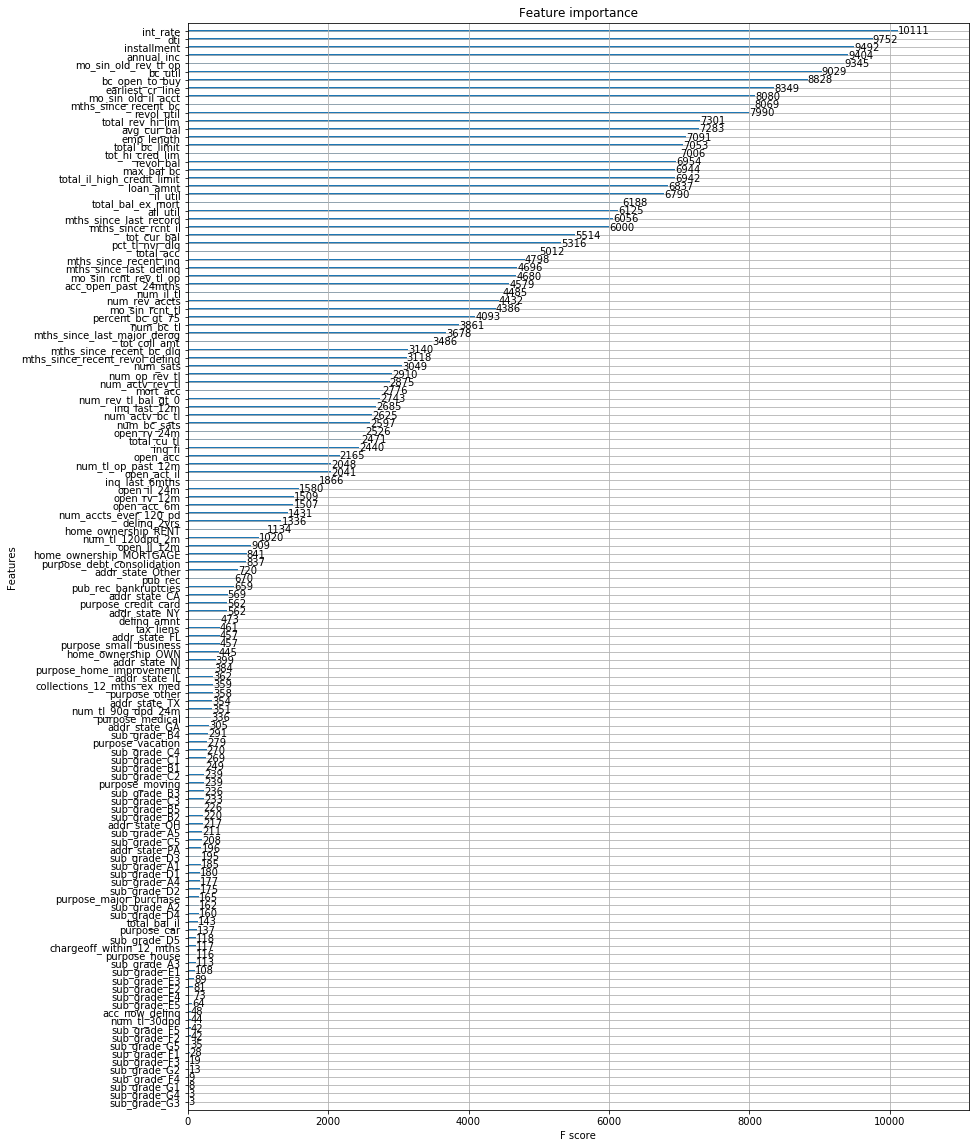

In [13]:
fig, ax = plt.subplots(1,1,figsize=(14, 20))
plot_importance(new_model.model, ax=ax)

In [7]:
# get listed loan
loans = DataHelper.get_listed_loandata()
loans.shape

(54, 81)

In [8]:
# prediction
pred = new_model.predict_model(loans)
pred.shape

(54,)